# Bayesian optimisation of a deep neural network on the MNIST dataset

For an introduction to bayesian hyperparameter optimisation see the notebook: [Introduction to bayesian hyperparameters optimization](https://github.com/AlxClt/Hyperparameters/blob/master/Introduction%20to%20bayesian%20hyperparameters%20optimization.ipynb).

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a widely known dataset of a common use in deep learning beginners tutorials. It consists of 60000 train images of handwritten digits and 10000 test images, and allows to reach high accuracy scores even with limited computational power.

In this notebook, we will explore different settings of bayesian hyperparameters optimisation with each time the goal to beat 99% accuracy. The optimisation process will be run on [google collaboratory notebooks](https://colab.research.google.com/notebooks/welcome.ipynb) which allow the free use of Tesla K80 GPUs.

The whole code for this notebook can be found [there](https://github.com/AlxClt/Hyperparameters/blob/master/MNIST_Opt.py)

In [104]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
from scipy.stats import norm
import pandas as pd

import time
import pickle
import pprint

from MNIST_Models import MNISTModel, MoreFlexibleMNISTModel

from hyperopt import fmin, tpe, hp, rand, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll.stochastic import sample

import matplotlib.pyplot as plt

## Experience 1: the learning parameters

Let's start with something light! In this first experience we will tune only the learning and regularization parameters. We will not attempt yet to modify the structure of the network. 

The learning parameters (learning algorithm, learning rate, learning rate decay...) and the regularization ones (dropout, early stopping...) are crucial elements. The performance of a deep learning algorithm can vary a lot with them, as we will see further below. 

First, we need to define the structure of the network :

* 6x6 convolutional layer with 6 output channels with stride of 1
* 5x5 convolutional layer with 12 ouptut channels with stride of 2
* 4x4 convolutional layer with 24 output channels with stride of 2

* Dense layer with 200 units and relu activation
* Dropout layer 
* Sofmax layer with 10 output units

The loss will be the cross entropy loss. This structure is interesting because with the right set of learning parameters it can reach 99.2% of accuracy in 5 epochs only.

Now we have to define the learning hyperparameters to tune. We will retain:
* Optimizer algorithm: one among Adam, RMSProp and simple gradient descent
* The hyperparameters of the optimization algorithm
* The initial learning rate
* Number of steps after which applying weight decay
* The learning rate decay ratio of exponential learning rate decay
* The minimum learning rate (lower limit for decay)

The optimization (see the [intro notebook](https://github.com/AlxClt/Hyperparameters/blob/master/Introduction%20to%20bayesian%20hyperparameters%20optimization.ipynb) for more details) will be done using hyperopt and the TPE algorith for 250 steps:

<br/>
### Running the optimization

In [1]:
N_EPOCH=5
BATCH_SIZE=64
MAX_STEPS = int(N_EPOCH*60000//BATCH_SIZE)

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

#function that takes the set of hyperparameters and returns 1-accuracy
def apply_mnist_model(hparams):

    batch = tf.placeholder(tf.float32, [None, 784])
    target = tf.placeholder(tf.float32, [None, 10])
    step = tf.placeholder(tf.int32)
    batch_size = tf.placeholder(tf.int32)
    pkeep = tf.placeholder(tf.float32)
    
    pkeep_=hparams.pop('pkeep')
    
    model = MNISTModel(batch, target, step, batch_size,pkeep, **hparams['optimizer_hparams'])
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    for i in range(MAX_STEPS):
        images, labels = mnist.train.next_batch(BATCH_SIZE)
        _,loss = sess.run(model.optimize, {batch: images, target: labels,
                                           step:i, batch_size:BATCH_SIZE, 
                                           pkeep:pkeep_})
              
    images, labels = mnist.test.images, mnist.test.labels
    accuracy = sess.run(model.accuracy, {batch: images, target: labels, 
                                         step:i, batch_size:BATCH_SIZE, 
                                         pkeep:1.0})
    
    print('Progress: 100% - Test accuracy {:6.2f}%'.format( 100 * accuracy))

    sess.close()
    
    #be careful to return 1-accuracy since we wish to minimize the score
    return(1-accuracy)

C:\Users\Alexis\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We have to define the search space:

In [ ]:
space = {'optimizer_hparams':
         hp.choice('optimizer',[
                        {'optimizer_algo':
                             {'optimizer':tf.train.AdamOptimizer,
                              'beta1':hp.uniform('beta1',0.8,0.99),'beta2':hp.uniform('beta2',0.9,0.9999),'epsilon':hp.uniform('epsilon',0.01,1)},
               
                         'max_lr':hp.loguniform('learning_rate_adam', np.log(0.001), np.log(0.2)),
                         'min_lr_ratio':hp.choice('min_lr_ratio_adam',[1,5,10,20,30,40,50,75,100,200,500,1000]),
                         'decay_step':hp.quniform('decay_step_adam',200,MAX_STEPS,50), 
                         'decay_rate':hp.uniform('decay_rate_adam',0,1)},
                        
                        {'optimizer_algo':
                             {'optimizer':tf.train.RMSPropOptimizer,
                              'decay':hp.uniform('decay',0.1,0.99),'momentum':hp.uniform('momentum',0.1,0.99),'epsilon':1e-10,},
                
                         'max_lr':hp.loguniform('learning_rate_rmsprop', np.log(0.001), np.log(0.2)),
                         'min_lr_ratio':hp.choice('min_lr_ratio_rmsprop',[1,5,10,20,30,40,50,75,100,200,500,1000]),
                         'decay_step':hp.quniform('decay_step_rmsprop',200,MAX_STEPS,50), 
                         'decay_rate':hp.uniform('decay_rate_rmsprop',0,1)},
                              
                        {'optimizer_algo':
                             {'optimizer':tf.train.GradientDescentOptimizer},
                             
                         'max_lr':hp.loguniform('learning_rate_gdopt', np.log(0.001), np.log(0.2)),
                         'min_lr_ratio':hp.choice('min_lr_ratio_gdopt',[1,5,10,20,30,40,50,75,100,200,500,1000]),
                         'decay_step':hp.quniform('decay_step_gdopt',200,MAX_STEPS,50), 
                         'decay_rate':hp.uniform('decay_rate_gdopt',0,1)}
                   ]),
          'pkeep':hp.uniform('pkeep',0.3,0.9)}

Now we can run the optimization process. **Beware, this takes some time and it is not designed to run on a simple jupyter notebook**. If you want to reproduce the results, use [this colab notebook](https://colab.research.google.com/drive/1LAHZWlAiUd5yDGzx6wV51OEKcwHajlz_).

In [ ]:
def objective(hparams):
    return({
        'loss': apply_mnist_model(hparams),
        'hparams':hparams,
        'status': STATUS_OK,
        'eval_time': time.time()
        })
    
trials_tpe = Trials()

#uncomment this part if you want to run the optimization process
"""
best_tpe = fmin(objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials_tpe)
"""


<br/>
### Looking at the results

The optimisation process ran in roughly 5 hours on the collab notebook for 250 steps. We use the trials objects to get information on the result.

Visualizing the results can be interesting  becaus it may provide useful insights and maybe a better understanding of how the different parameters influe on the final score.

In [26]:
with open('data/trials_tpe_mnist_step1','rb') as f:
    trials_tpe=pickle.load(f)

print('Best Accuracy: {:.2f}%'.format(100*(1-trials_tpe.best_trial['result']['loss'])))

Best Accuracy: 99.28%


**We successfuly beat 99.2% accuracy!** 

We can dig into the results to analyse the choice of hyperparameters made by the TPE algorithm. 

In [29]:
def get_values(trial,*keys):
    res_={}
    for key in keys:
        res_[key]=[]
    for t in trial:
        vals=t['misc']['vals']
        for key in keys:
            if key=='score':
                res_['score'].append(1-t['result']['loss'])
            else:
                if len(vals[key])>0:
                    res_[key].append(vals[key][0])
                else:
                    res_[key].append(np.nan)
        
    return(res_)

#### Best learning algorithm?

Who is the best learning algorithm according to the TPE algorithm? Let's look at hiw many times each algorithm has been sampled:

In [40]:
algorithm_choice = pd.DataFrame(get_values(trials_tpe,'optimizer','score'))

#We need to set the labels, since hp.choice returns the index of its choice, not the name of the algorithm

mapping = {0:'Adam',1:'RMSProp',2:'SGD'}
algorithm_choice.optimizer=algorithm_choice.optimizer.apply(lambda x : mapping[x])
algorithm_choice=algorithm_choice.groupby('optimizer').agg({'optimizer':'count','score':max})
algorithm_choice.rename({'optimizer':'count','score':'max score reached'})
print(algorithm_choice)

           optimizer   score
optimizer                   
Adam             137  0.9928
RMSProp           33  0.9894
SGD               30  0.9897


The TPE algorithm shows a strong preference for the Adam optimizer. This reflets into the max score reached, we see that both RMSProp and SGD fails to beat 99% accuracy. This doesn't mean that Adam optimizer is necessarly the best choice. Indeed a finer tuning of RMSProp could also beat 99% accuracy (ref!), however Adam seems to be able to reach higher scores quickly.

#### Parameters distribution

Let's visualize the distrbution of hyperparameters for the adam algorithm : 

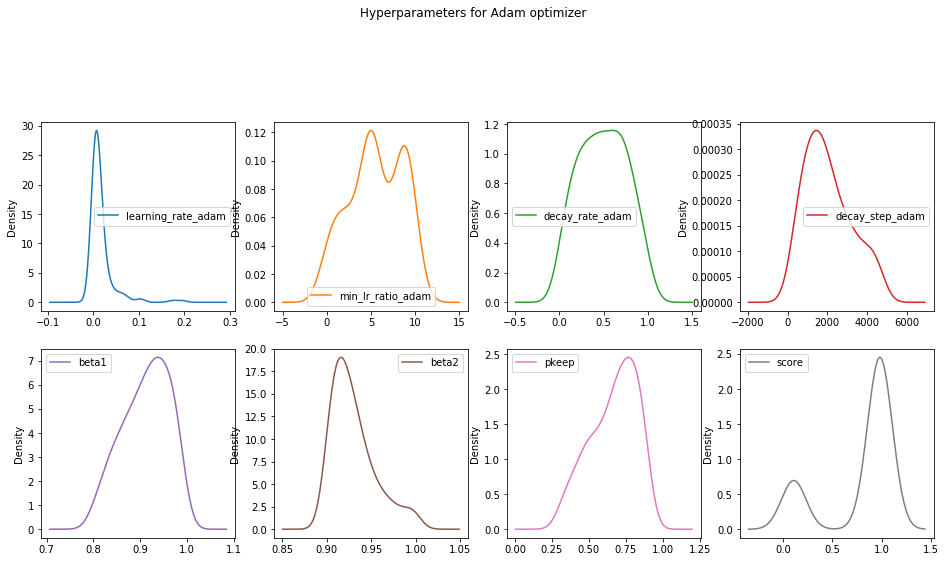

Best configuration: 

{   'beta1': [0.9614914985667171],
    'beta2': [0.9238546410322698],
    'decay': [],
    'decay_rate_adam': [0.7123079184754414],
    'decay_rate_gdopt': [],
    'decay_rate_rmsprop': [],
    'decay_step_adam': [1150.0],
    'decay_step_gdopt': [],
    'decay_step_rmsprop': [],
    'epsilon': [0.6308367194603324],
    'learning_rate_adam': [0.00887118899313656],
    'learning_rate_gdopt': [],
    'learning_rate_rmsprop': [],
    'min_lr_ratio_adam': [5],
    'min_lr_ratio_gdopt': [],
    'min_lr_ratio_rmsprop': [],
    'momentum': [],
    'optimizer': [0],
    'pkeep': [0.8096324863520263]}


In [61]:
optimizers_params=pd.DataFrame(get_values(trials,'learning_rate_adam', 'min_lr_ratio_adam', 'decay_rate_adam', 'decay_step_adam', 'beta1', 'beta2',
                                         'pkeep','score'))


optimizers_params.plot(kind='kde',subplots=True, sharex=False, layout=(4,4),title='Hyperparameters for Adam optimizer',figsize=(16,16))
plt.show()

print('Best configuration: \n')
pprint.PrettyPrinter(indent=4).pprint(trials.best_trial['misc']['vals'])

Plotting the initial learning rate with the score allows to clearly distingush the area where the optimal learning rate should lay:

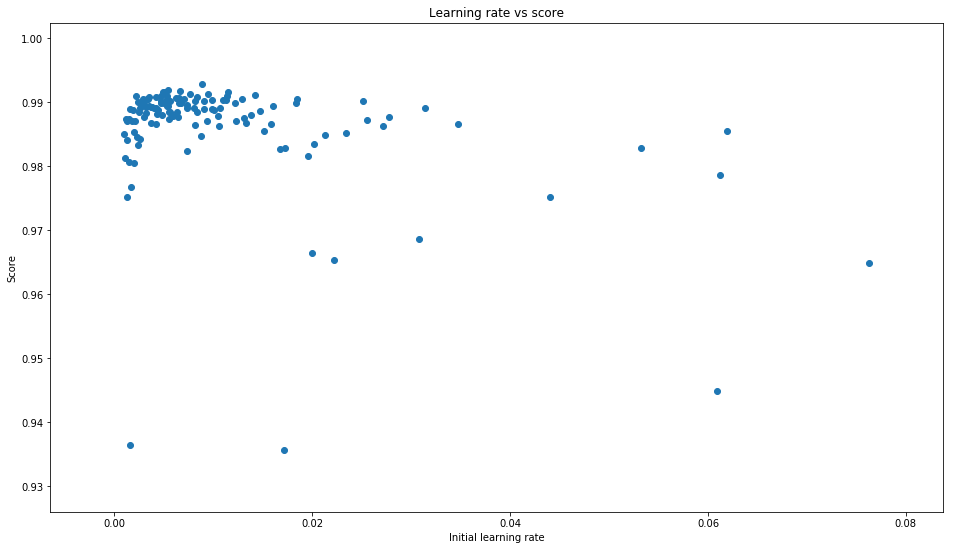

In [92]:
plt.figure(figsize=(16,9))
plt.scatter(optimizers_params[optimizers_params.score>0.9].learning_rate_adam,optimizers_params[optimizers_params.score>0.9].score)
plt.title('Learning rate vs score')
plt.xlabel('Initial learning rate')
plt.ylabel('Score')
plt.show()

#### Dropout probability

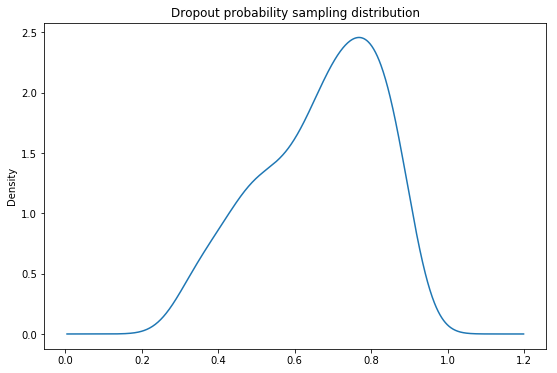

In [102]:
dpout = pd.DataFrame(get_values(trials_tpe,'pkeep','score'))

dpout['pkeep'].plot(kind='kde',title='Dropout probability sampling distribution',figsize=(9,6))
plt.show()

<br/>

<br/>

## Experience 2: Tuning the whole structure

We will now attempt to tune the whole network structure. In order to limit the complexity of the process we will not give the choice between several optimizers and will use Adam optimizer, which has proven to be good for this task. We will even constrint Adam algorithm to use tensorflow's default arguments for its hyperparameters.

The structure of the model will have to respect the following constraints:

* Convolutional layer stack: Between 1 and 4 layers, with max 100 output channels and decreasing filter size
* Dense layer stack: Between 1 and 3 dense layers with max 2000 units

We let then the TPE algorithm find the optimal structure! One can notice the use of the hyperopt STATUS_FAIL object: when we don't succed in implementing a constraint in the search space, we can still test it in the objective function and return a STATUS_FAIL to the TPE algorithm if the constraint is not satisfied. The TPE algorithm will then ignore the bad set of hyperparameters values in its update. 

As usual, let's define a search space. It is clear that th size of the next convolutional layer depends on the last layer size, however hyperopt doesn't explicitly admit dependant parameters definition except for the hp.choice, which is not suitable for continutous dependant parameters. The trick that we will use to reflect this dependancy is to definr the number of units for the first layer and define a multiple of this number for the next layer. We will use normal priors to express our preference for layer that double in size.

In [106]:

N_EPOCH=5
BATCH_SIZE=64
MAX_STEPS = int(N_EPOCH*60000//BATCH_SIZE)

#Bounds for the search space

space = {
        'conv_layers':hp.choice('conv_layers',[
                {'conv_depth':1, 
                 'channels':{
                         'conv_channels_1':hp.quniform('conv_channels_1_1',2,12,2)
                         }, 
                 'filters': {
                         'conv_filter_1':hp.quniform('conv_filter_1_1',2,32,2)
                         }},
                {'conv_depth':2, 
                 'channels':{
                         'conv_channels_1':hp.quniform('conv_channels_1_2',2,12,2),
                         'conv_channels_mult_2':hp.normal('conv_channels_mult_2_2',2,1)
                         }, 
                 'filters': {
                         'conv_filter_1':hp.quniform('conv_filter_1_2',2,32,2),
                         'conv_filter_mult_2':hp.normal('conv_filter_mult_2_2',2,1)
                         }},
                {'conv_depth':3, 
                 'channels':{
                         'conv_channels_1':hp.quniform('conv_channels_1_3',2,12,2),
                         'conv_channels_mult_2':hp.normal('conv_channels_mult_2_3',2,1),
                         'conv_channels_mult_3':hp.normal('conv_channels_mult_3_3',2,1)
                         }, 
                 'filters': {
                         'conv_filter_1':hp.quniform('conv_filter_1_3',2,32,2),
                         'conv_filter_mult_2':hp.normal('conv_filter_mult_2_3',2,1),
                         'conv_filter_mult_3':hp.normal('conv_filter_mult_3_3',2,1)
                         }},
                {'conv_depth':4, 
                 'channels':{
                         'conv_channels_1':hp.quniform('conv_channels_1_4',2,12,2),
                         'conv_channels_mult_2':hp.normal('conv_channels_mult_2_4',2,1),
                         'conv_channels_mult_3':hp.normal('conv_channels_mult_3_4',2,1),
                         'conv_channels_mult_4':hp.normal('conv_channels_mult_4_4',2,1)
                         }, 
                 'filters': {
                         'conv_filter_1':hp.quniform('conv_filter_1_4',2,32,2),
                         'conv_filter_mult_2':hp.normal('conv_filter_mult_2_4',2,1),
                         'conv_filter_mult_3':hp.normal('conv_filter_mult_3_4',2,1),
                         'conv_filter_mult_4':hp.normal('conv_filter_mult_4_4',2,1)
                         }}
                ]),
        
        'dense_layers':hp.choice('dense_layers',[
                {'dense_depth':1, 
                 'dense_units_1':hp.quniform('dense_units_1_1',50,500,50)},
                {'dense_depth':2, 
                 'dense_units_1':hp.quniform('dense_units_1_2',50,500,50), 
                                 'dense_units_mult_2': hp.normal('dense_units_mult_2_2',2,1)},
                {'dense_depth':3, 
                 'dense_units_1':hp.quniform('dense_units_1_3',50,500,50), 
                                 'dense_units_mult_2':hp.normal('dense_units_mult_2_3',2,1),
                                 'dense_units_mult_3':hp.normal('dense_units_mult_3_3',2,1)},
                ]),
        
        'optimizer_hparams':{
                'optimizer_algo':{'optimizer':tf.train.AdamOptimizer,
                                  'optimizer_params':{'beta1':0.9,
                                                      'beta2':0.99,
                                                      'epsilon':1e-08}},
                        
                'max_lr':hp.loguniform('learning_rate_adam', np.log(0.001), np.log(0.2)),
                'min_lr_ratio':hp.choice('min_lr_ratio_adam',[1,10,20,30,40,50,75,100,200,500,1000]),
                'decay_step':hp.quniform('decay_step_adam',200,MAX_STEPS,50), 
                'decay_rate':hp.uniform('decay_rate_adam',0,1)},

        'pkeep':hp.uniform('pkeep',0.3,1)
        }

Let's draw a sample from this search space:

In [108]:
testspace=sample(space)
pprint.PrettyPrinter(indent=2).pprint(sample(testspace))

{ 'conv_layers': { 'channels': {'conv_channels_1': 6.0},
                   'conv_depth': 1,
                   'filters': {'conv_filter_1': 10.0}},
  'dense_layers': { 'dense_depth': 3,
                    'dense_units_1': 150.0,
                    'dense_units_mult_2': 3.1394330983170438,
                    'dense_units_mult_3': 1.9124562317904725},
  'optimizer_hparams': { 'decay_rate': 0.5771711574542334,
                         'decay_step': 2350.0,
                         'max_lr': 0.10192790146860131,
                         'min_lr_ratio': 500,
                         'optimizer_algo': { 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>,
                                             'optimizer_params': { 'beta1': 0.9,
                                                                   'beta2': 0.99,
                                                                   'epsilon': 1e-08}}},
  'pkeep': 0.6912820944104268}


Let's write the objective function. You can see that it might return STATUS_FAIL:

In [ ]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

def apply_mnist_model(hparams):

    batch = tf.placeholder(tf.float32, [None, 784])
    target = tf.placeholder(tf.float32, [None, 10])
    step = tf.placeholder(tf.int32)
    batch_size = tf.placeholder(tf.int32)
    pkeep = tf.placeholder(tf.float32)
    
    pkeep_=hparams.pop('pkeep')
    
    model = MoreFlexibleMNISTModel(batch, target, step, batch_size,pkeep, **hparams)

    if model.go_flag:
    
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
            
        for i in range(MAX_STEPS):
                        
            images, labels = mnist.train.next_batch(BATCH_SIZE)
            _,loss = sess.run(model.optimize, {batch: images, target: labels,
                                               step:i, batch_size:BATCH_SIZE, 
                                               pkeep:pkeep_})
       
        images, labels = mnist.test.images, mnist.test.labels
        accuracy = sess.run(model.accuracy, {batch: images, target: labels, 
                                             step:i, batch_size:BATCH_SIZE, 
                                             pkeep:1.0})
        
        print('Progress: 100% - Test accuracy {:6.2f}%'.format( 100 * accuracy))
    
        sess.close()
        
        #be careful to return 1-accuracy since we wish to minimize the score
        return(1-accuracy, STATUS_OK)
        
    else:
        print('invalid configuration')
        return(0, STATUS_FAIL)


In [ ]:
def objective(hparams):
    
    loss, status = apply_mnist_model(hparams)
    
    return({
        'loss':loss ,
        'hparams':hparams,
        'status': status,
        'eval_time': time.time()
        })
    
trials_tpe = Trials()

#Uncomment if you want to run the otpimization process
"""
best_tpe = fmin(objective,
                space=space,
                algo=tpe.suggest,
                max_evals=500,
                trials=trials_tpe)
"""